To meet Francesco's request, I diceded to implement a Linear Regression Model.

In general, statistical modeling is a way of finding relationship between **explanatory variables**, in our case the characteristics of the diamonds, and a **response variable**, in our case the price of the diamond.

Linears Regression Models, while being relatively simple models compared to the increasingly powerful Machin Learning models that exist today,allow us to  describes the relationship between a dependent variable, y, and one or more independent variables X, providing a clear interpretation of which factors influence the value of the responso varible y.

In [207]:
import numpy as np
import pandas as pd
import plotly.express as px
import ipywidgets
import ydata_profiling
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [268]:
url = 'https://raw.githubusercontent.com/Jacoposigno1999/interviews-data-science-assignment/main/datasets/diamonds/diamonds.csv'
df = pd.read_csv(url)
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82
...,...,...,...,...,...,...,...,...,...,...
4995,0.38,Ideal,H,VVS2,62.3,53.3,832,4.65,4.69,2.91
4996,0.33,Premium,G,VVS2,61.3,59.0,927,4.45,4.42,2.72
4997,1.25,Ideal,J,VVS2,62.1,56.0,5980,6.81,6.84,4.24
4998,0.31,Premium,F,VS2,62.9,58.0,802,4.31,4.27,2.70


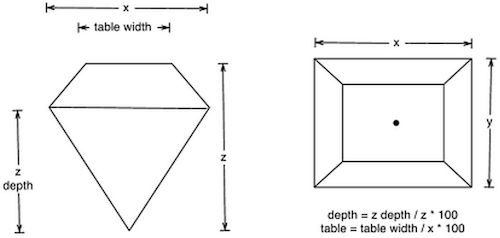

# Data exploration 



In [209]:
profile = ProfileReport(df, title = "Data Exploration Report", explorative = True,html={'style':{'full_width':False}})

In [270]:
df['cut'].value_counts()


Ideal        1992
Premium      1294
Very Good    1099
Good          457
Fair          158
Name: cut, dtype: int64

 <font color='red'>
   
! Run the following chunk only if you are interested in all the data exploration part (Distribution of varibles, relationship between variables, correlation matrix, ecc..) !
</font>
   

In [210]:
#profile.to_notebook_iframe()

## Data Cleaning 

From a first view of the data we can see that some diamond records are saved in the dataframe with a price of -1, this is probably an error or a default value assigned when other data wasn't available. We procede to remove those records.

In [211]:
id_0 = df[df['price']<0].index
df = df.drop(id_0)
#df['price'].describe()

We can also see that an observation has x = y = z = 0, so we also remove this observation.

In [212]:
df = df.drop(df[df['x']==0].index)

### Removing outliers 

Looking at the box-plot of the variables 'table' and 'depth', we can see how in one case the biggere value is much bigger than all the other, and the same but with respect to the minimun for the other case.

<AxesSubplot: ylabel='depth'>

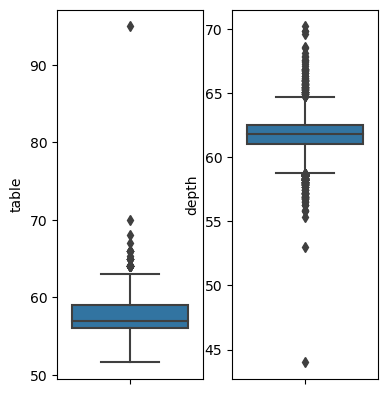

In [213]:
plt.subplot(1,3,1)
sns.boxplot(y = 'table', data = df)

plt.subplot(1,3,2)
sns.boxplot(y = 'depth', data = df)


Let's visualize the 2 diamonds corresponding to these values.

In [214]:
print(df[df['table'] == df['table'].max()])
print(df[df['depth'] == df['depth'].min()])

     carat   cut color clarity  depth  table  price     x     y     z
679   2.01  Fair     F     SI1   58.6   95.0  13387  8.32  8.31  4.87
      carat   cut color clarity  depth  table  price     x     y     z
1889    1.0  Fair     G     VS2   44.0   53.0   4032  6.31  6.24  4.12


Although these values could be true and therefore we should face a very small diamond and a very large one, I decided to remove both the records, since these are two observations that are very different from all other data and could therefore affect the results of our model.

In [215]:
df = df.drop(df[df['table']==95].index)
df = df.drop(df[df['depth']==44].index)


### Some plots to better understand data


In [216]:
#px.histogram(df, x ="price", color = "color")
#px.histogram(df, x ="price", color = "cut")
px.histogram(df, x ="price", color = "clarity")

From these plots we can observe as color, cut or clarity, considered separately they do not give us any insights about the price.

<AxesSubplot: xlabel='clarity', ylabel='carat'>

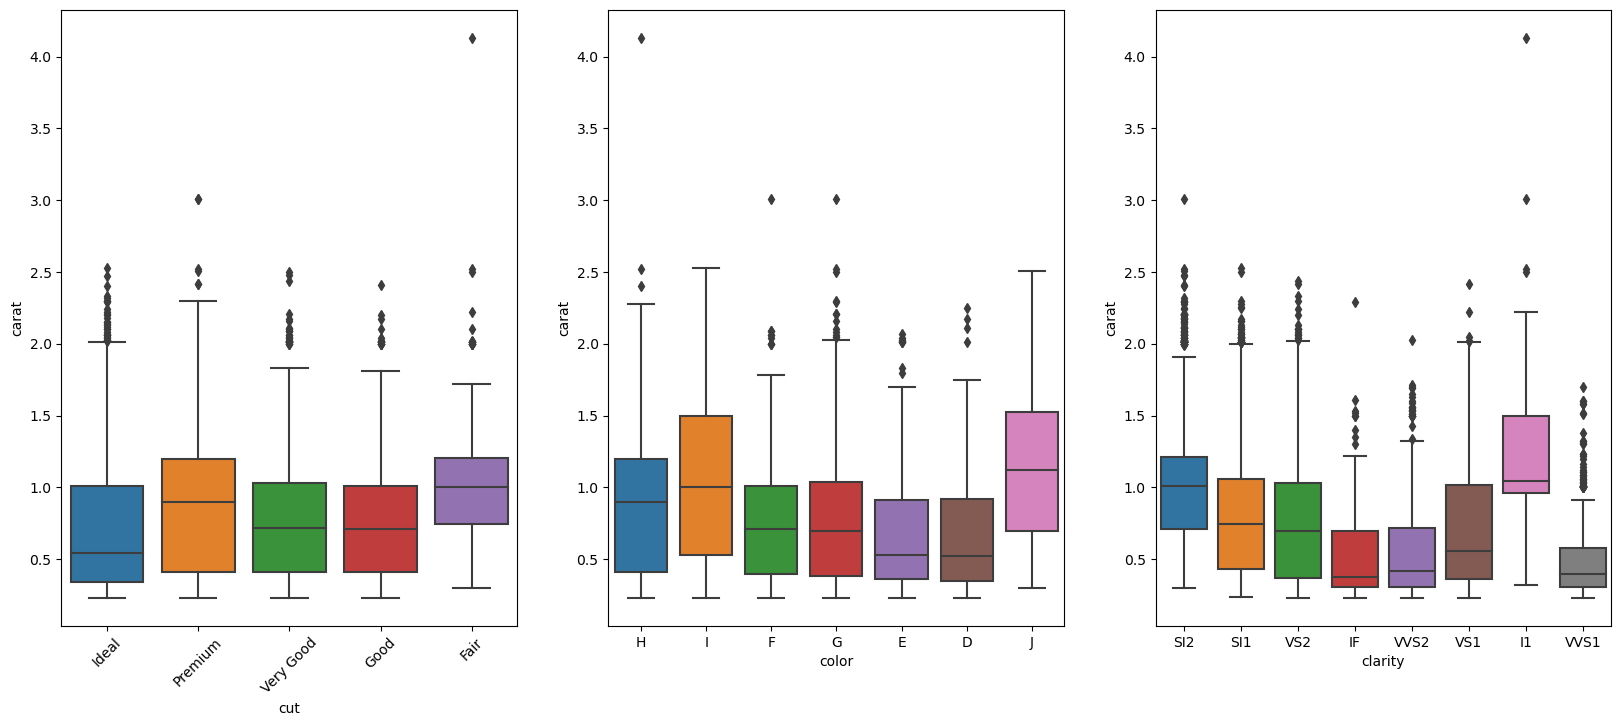

In [217]:
plt.figure(figsize = (20,8))
plt.subplot(1,3,1)
sns.boxplot(x = 'cut', y = "carat", data = df)
plt.xticks(rotation = 45)

plt.subplot(1,3,2)
sns.boxplot(x = 'color', y = "carat", data = df)

plt.subplot(1,3,3)
sns.boxplot(x = 'clarity', y = "carat", data = df)

From these plots we can see how bigger diamonds(high value of carat), tend to have worse clarity quality and a more yellowish color, while the quality of the cut doesn't seem to be influenced by the carat.

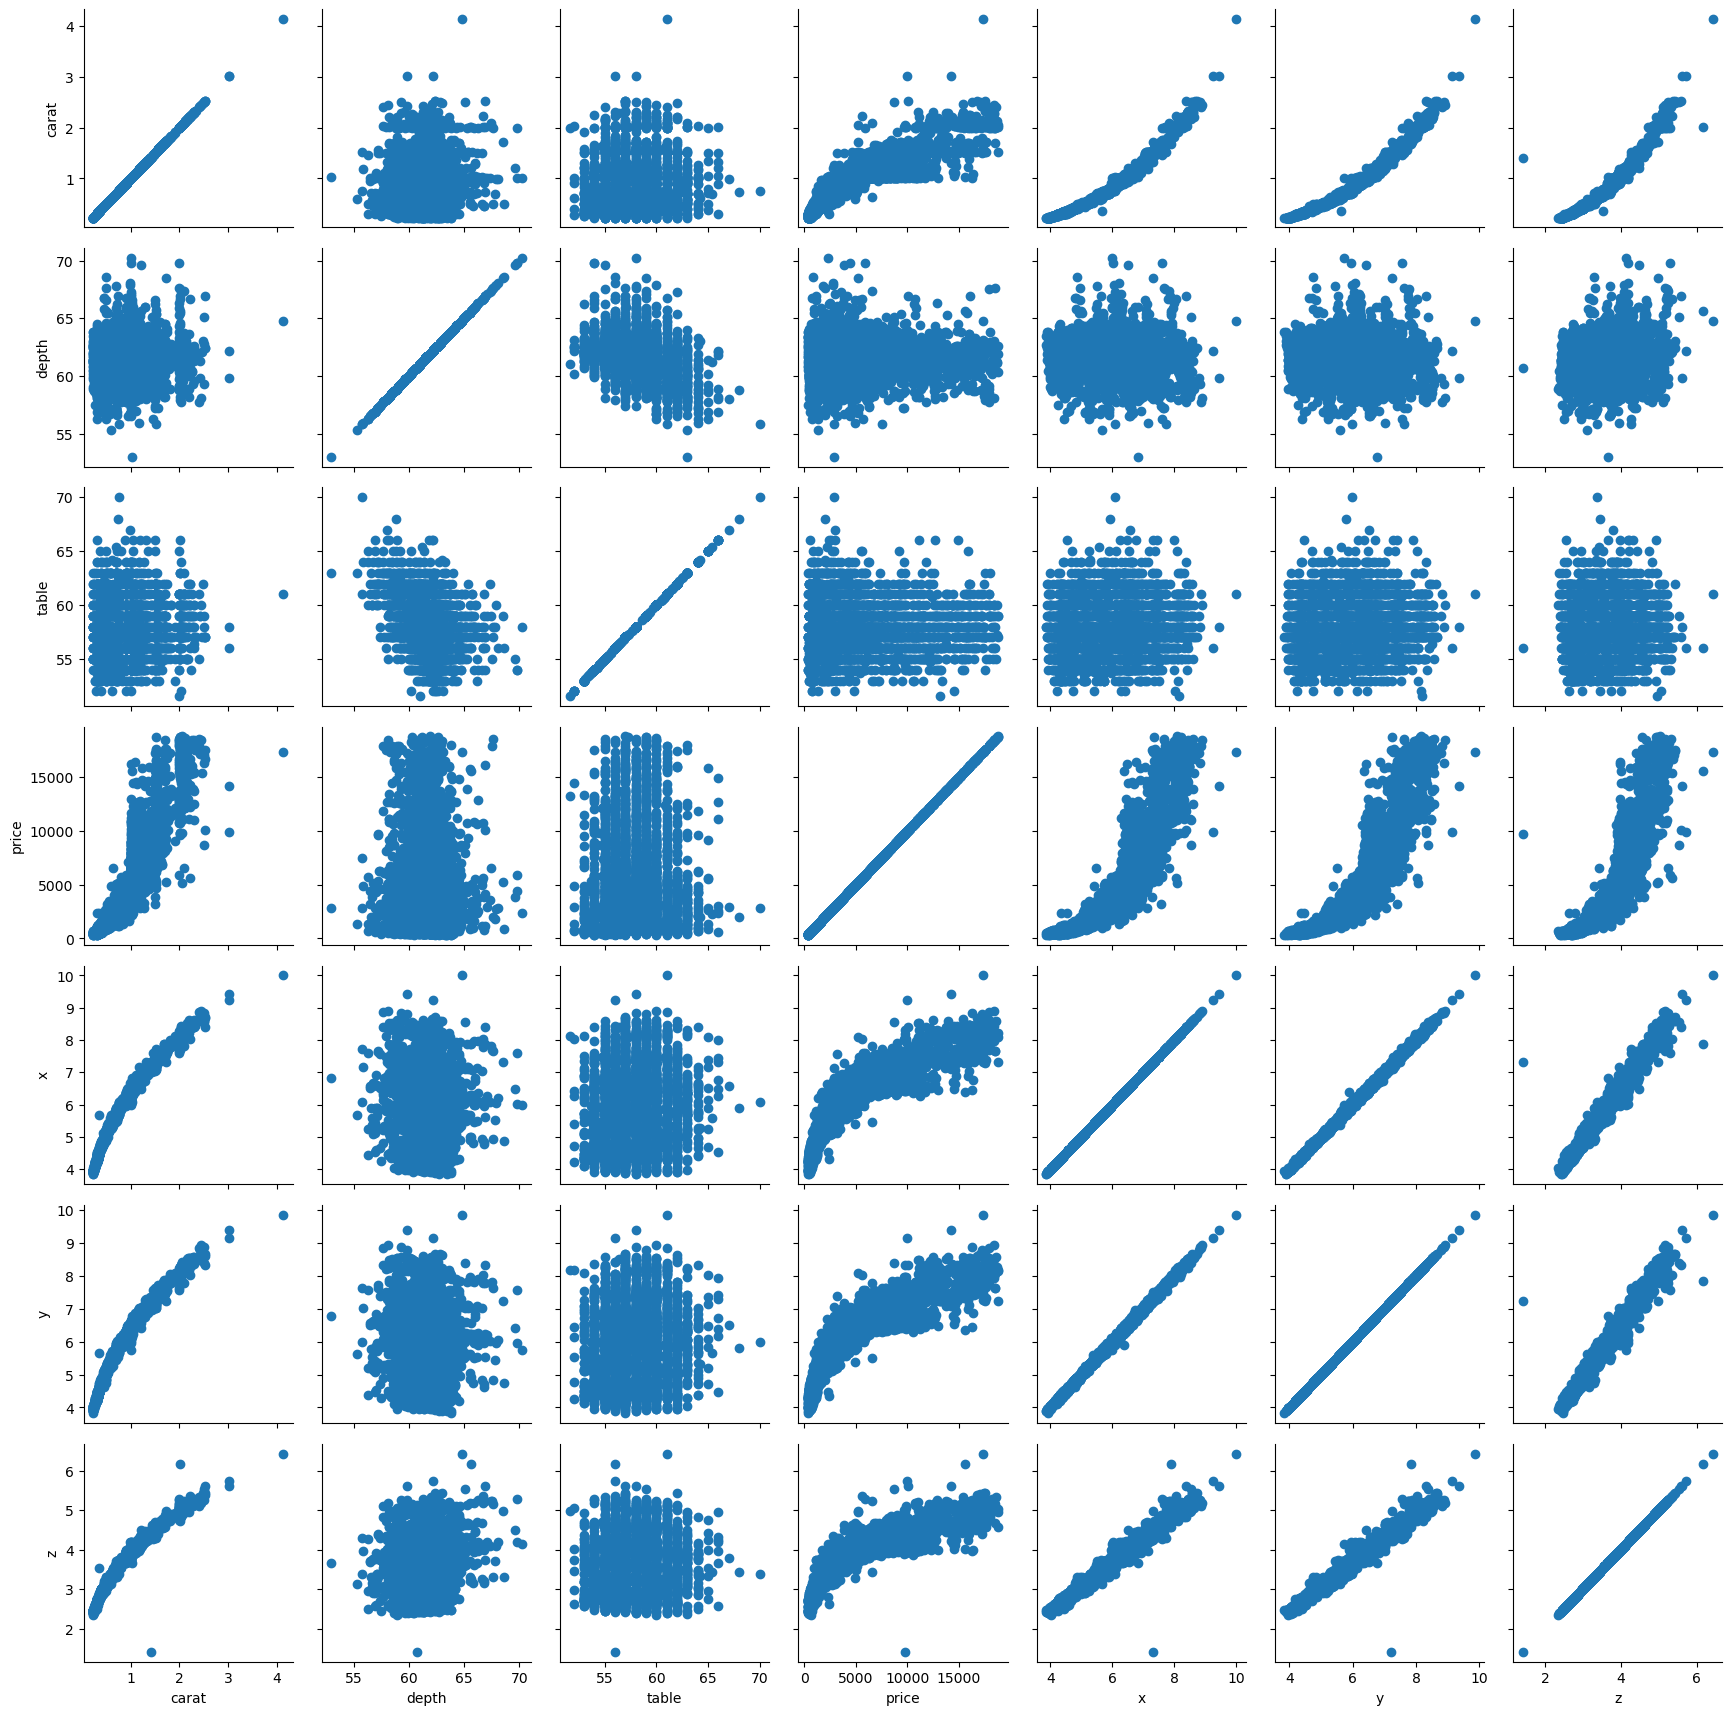

In [218]:
selection = ["carat", "depth", "table", "price", "x", "y", "z"]
scatter = sns.PairGrid(df[selection])
scatter.map(plt.scatter)

As we can see from the plot x is almost perfctly linear correlated with z and y, so to avoid *collinearity* we decided to remove y and z from our covariates.

In [219]:
df.drop(labels='y', axis=1, inplace=True)
df.drop(labels='z', axis=1, inplace=True)

 <font color='blue'>
   
### Explaining Francesco what collinearity is

Collinearity occurs when we have that 2 explanatory variables (the variables that we use to understand the price of a diamond) have almost a linear relationship. In this case we will have that our estimated coefficients (i.e. the values that tell us how much an explanatory varible influence the price of a diamond) won't be reliable.

We can look at this phenomenon also from a more practical point of view, suppose we know that the price of a diamond depends on its size, so x, y and z. If we want to estimate the price of a diamond we will need to take these 3 measurements. But if we know that y and z are linearly correlated to x, we have that if we know the value of x, we will know also the value of y and z quite accurately. So insted of loosing time in take 3 measurements for each diamonds, we will need just to take one measurement.
</font> 



Also x seems to be higly correlated with carat. We calculate the VIF to see if we can have other collinearity problems.
But before we have to deal with the categorical varibles.

### Dealing with categorical varible 

Aggregating color grading scale of diamonds in order to have less category, following the criteria in the following image.

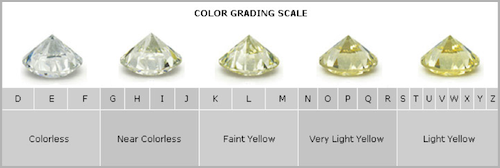

In [220]:
df.replace(['D', 'E', 'F'], 'Colorless', inplace=True)
df.replace(['G', 'H', 'I','J'], 'Near Colorless', inplace=True)
df.replace(['K', 'L', 'M'], 'Faint Yellow', inplace=True)
df.replace(['N', 'O', 'P','Q','R'], 'Very Light Yellow', inplace=True)
df.replace(['S','T', 'U','W','X','Y','Z'], 'Light Yellow', inplace=True)

df['color'].value_counts()

Near Colorless    2621
Colorless         2366
Name: color, dtype: int64

Notice that with these specif data we will have only 'colorless' and 'near colorless' diamonds, so when they will be dummizated we will have 'colorness' = 0 and 'near colorness' = 1


We do the same thing with respect to the clarity grading.

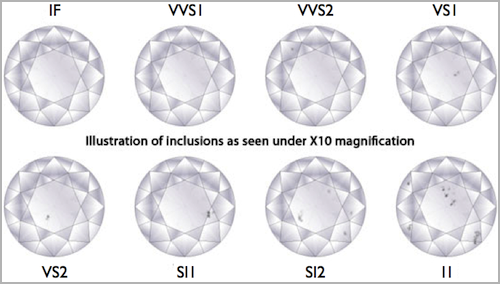

In [221]:
df.replace(['IF', 'VVS1','VVS2'], 'Top', inplace=True)
df.replace([ 'VS1', 'VS2','SI1'], 'Medium', inplace=True)
df.replace(['SI2', 'I1'], 'Low', inplace=True)

df['clarity'].value_counts()

Medium    3121
Top        959
Low        907
Name: clarity, dtype: int64

We can now traform our categorical data into dummy varibles.

In [222]:
df = pd.get_dummies(data=df, drop_first=True)
df[:2]

,carat,depth,table,price,x,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_Near Colorless,clarity_Medium,clarity_Top
0,1.10,62.0,55.0,4733,6.61,0,1,0,0,1,0,0
1,1.29,62.6,56.0,6424,6.96,0,1,0,0,1,1,0


## Features scaling

I decide to use a MinMax Scaler instead of a Standard Scaler because data do not follow a Normal Distribution. Notice that we need to be carefull with the MinMax scaler because it is sensitive to outliers.

In [223]:
from sklearn.preprocessing import MinMaxScaler

minmaxscaler = MinMaxScaler()

df['carat'] = minmaxscaler.fit_transform(df[['carat']]) #double parentesis because we have to pass a df
df['depth'] = minmaxscaler.fit_transform(df[['depth']]) 
df['table'] = minmaxscaler.fit_transform(df[['table']]) 
df['x'] = minmaxscaler.fit_transform(df[['x']]) 
#df['z'] = minmaxscaler.fit_transform(df[['z']]) 

df[:2]

,carat,depth,table,price,x,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_Near Colorless,clarity_Medium,clarity_Top
0,0.223077,0.523256,0.184783,4733,0.447883,0,1,0,0,1,0,0
1,0.271795,0.558140,0.239130,6424,0.504886,0,1,0,0,1,1,0


### VIF

In [263]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif= vif.sort_values(by=['VIF'], ascending=False) #discending order

    return(vif)

calc_vif(df.drop('price', axis=1))

,variables,VIF
3,x,87.629589
0,carat,57.373679
1,depth,16.812753
2,table,9.862248
5,cut_Ideal,8.677308
6,cut_Premium,6.435859
7,cut_Very_Good,5.576172
9,clarity_Medium,4.673440
4,cut_Good,3.039650
10,clarity_Top,2.360272


In [262]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.loc[:, X.columns != 'carat'].columns
    vif["VIF"] = [variance_inflation_factor(X.loc[:, X.columns != 'carat'].values, i) for i in range(X.loc[:, X.columns != 'carat'].shape[1])]
    vif= vif.sort_values(by=['VIF'], ascending=False) #discending order

    return(vif)

calc_vif(df.drop('price', axis=1))

,variables,VIF
0,depth,16.800041
1,table,9.499856
4,cut_Ideal,7.794908
5,cut_Premium,6.052708
6,cut_Very_Good,5.244279
8,clarity_Medium,4.655072
2,x,4.575641
3,cut_Good,2.913882
9,clarity_Top,2.360224
7,color_Near_Colorless,2.233872


We see very high value for the VIF, we should try to fit different models escludin `x` or `carat`.

# Regression 

In [225]:
#just renaming some columns
df. columns. values
df['cut_Very Good']
df.rename(columns={'cut_Very Good':'cut_Very_Good'}, inplace=True)
df.rename(columns={'color_Near Colorless':'color_Near_Colorless'}, inplace=True)
df[:4]

,carat,depth,table,price,x,cut_Good,cut_Ideal,cut_Premium,cut_Very_Good,color_Near_Colorless,clarity_Medium,clarity_Top
0,0.223077,0.523256,0.184783,4733,0.447883,0,1,0,0,1,0,0
1,0.271795,0.558140,0.239130,6424,0.504886,0,1,0,0,1,1,0
2,0.248718,0.470930,0.347826,5510,0.491857,0,0,1,0,1,1,0
3,0.325641,0.459302,0.239130,8770,0.581433,0,1,0,0,0,1,0


In [226]:
y = np.log(df['price'])  #take a log trasformation of the response variable to try to avoid heteroschedasticity
X = df.drop('price', axis=1)

### Model without carat

In [228]:
model_1 = linear_model.LinearRegression()

In [229]:
X_1 = X.loc[:, X.columns != 'carat']

model_1.fit(X_1 ,y)

LinearRegression()

In [230]:
#provo a calcolare reisdui e r2 su i dati train 
y_fit = model_1.predict(X_1)
r2_ = r2_score(y, y_fit)
print(r2_)

residual_fit = y - y_fit

0.9577011487595246


In [231]:
print('Intercept: ', model_1.intercept_)
intercept =  model_1.intercept_
Coefficients = model_1.coef_
Variables = X.loc[:, X.columns != 'carat'].columns.to_numpy()

np.stack((Variables, Coefficients) , axis=1)


Intercept:  5.290092436849472


array([['depth', 0.6743401624809637],
       ['table', 0.08768954413691898],
       ['x', 5.86918207284841],
       ['cut_Good', 0.11651651763767801],
       ['cut_Ideal', 0.19662155305533044],
       ['cut_Premium', 0.13726281239364813],
       ['cut_Very_Good', 0.1587063606573319],
       ['color_Near_Colorless', -0.209829856990757],
       ['clarity_Medium', 0.2935972599449954],
       ['clarity_Top', 0.5587961658362904]], dtype=object)

Text(0, 0.5, 'Error')

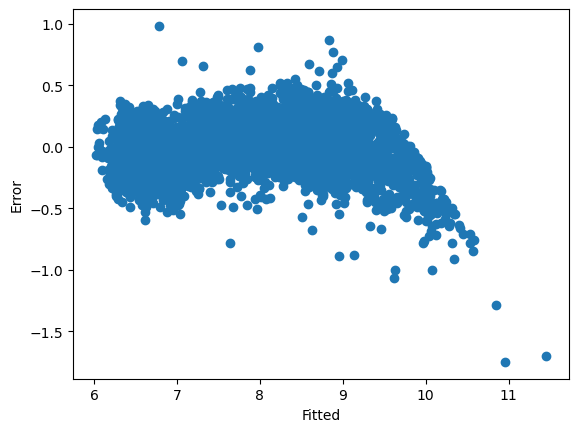

In [232]:
plt.scatter(y_fit, residual_fit)
plt.xlabel('Fitted')
plt.ylabel('Error')

Text(0, 0.5, 'True')

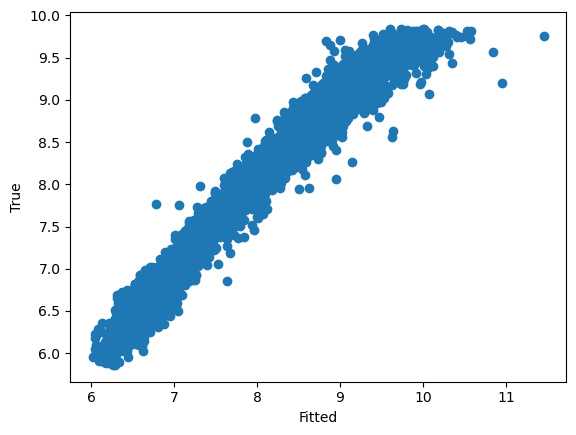

In [233]:
plt.scatter(y_fit,y)
plt.xlabel('Fitted')
plt.ylabel('True')

(-1.0, 1.0)

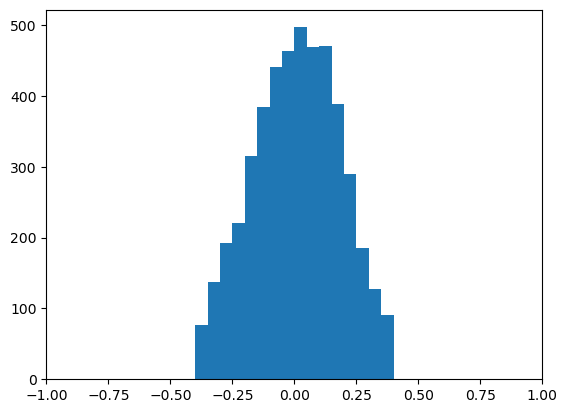

In [234]:
plt.hist(residual_fit,bins=[-0.4,-0.35,-0.3,-0.25,-0.2,-0.15,-0.1, -0.05,0,0.05, 0.1, 0.15, 0.2, 0.25,0.3, 0.35, 0.4])
plt.xlim(-1, 1)

### Model without x


In [235]:
model_2 = linear_model.LinearRegression()

In [236]:
X_2 = X.loc[:, X.columns != 'x']

model_2.fit(X_2 ,y)

LinearRegression()

In [237]:
#provo a calcolare reisdui e r2 su i dati train 
y_fit = model_2.predict(X_2)
r2_ = r2_score(y, y_fit)
print(r2_)

residual_fit = y - y_fit

0.8759483241525714


In [238]:
print('Intercept: ', model_2.intercept_)

intercept =  model_2.intercept_
Coefficients = model_2.coef_
Variables = X.loc[:, X.columns != 'x'].columns.to_numpy()

np.stack((Variables, Coefficients) , axis=1)

Intercept:  6.344773495755049


array([['carat', 8.434087100715674],
       ['depth', -0.09995762371264294],
       ['table', 0.06849464784837067],
       ['cut_Good', 0.08208351934778783],
       ['cut_Ideal', 0.14668991656704128],
       ['cut_Premium', 0.09493888631901642],
       ['cut_Very_Good', 0.11307865774819681],
       ['color_Near_Colorless', -0.21743299839619595],
       ['clarity_Medium', 0.26096567476826965],
       ['clarity_Top', 0.4348478730119675]], dtype=object)

Text(0, 0.5, 'Error')

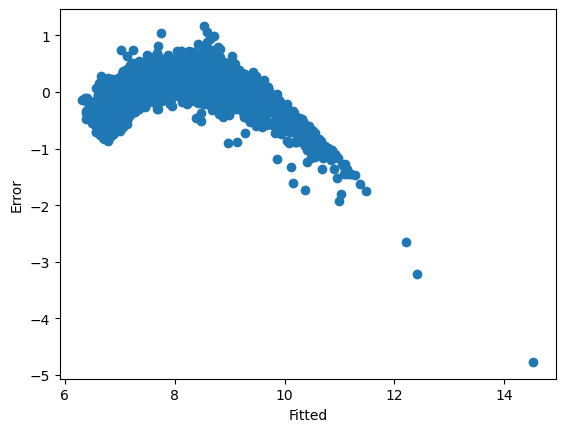

In [239]:
plt.scatter(y_fit, residual_fit)
plt.xlabel('Fitted')
plt.ylabel('Error')

(-1.0, 1.0)

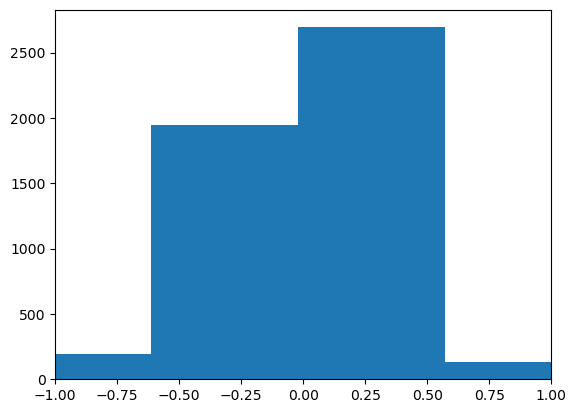

In [240]:
plt.hist(residual_fit)
plt.xlim(-1, 1)

### Cross Validation

From above results seems clear that the best model is the one without the varible 'x',both in terms of $R^{2}$ and diagnostic.

but let's anyway perform a K-fold cross validation in order to validate our results.

In [241]:
from sklearn.model_selection import cross_validate

In [242]:
#model = linear_model.LinearRegression()

cv_results_1 = cross_validate(model_1, X_1, y, cv = 10)
cv_results_2 = cross_validate(model_2, X_2, y, cv = 10)

In [258]:
#Mean of R2 scores 
mean_score_1 = cv_results_1['test_score'].mean()
mean_score_2 = cv_results_2['test_score'].mean()

print('Mean R2 score for the model without carat: ', mean_score_1 )
print('Mean R2 score for the model with carat: ', mean_score_2 )


Mean R2 score for the model without carat:  0.9573414100699781
Mean R2 score for the model with carat:  0.8747966392484663


We can state that the first model is better in explaining the variance among our data. So we will use it to explain Don Francesco which are carachteristics that it should watch to understand the value of a diamond.



In [244]:
intercept =  model_1.intercept_
Coefficients = model_1.coef_
Variables = X.loc[:, X.columns != 'carat'].columns.to_numpy()

coef = np.stack((Variables, Coefficients) , axis=1)

result = pd.DataFrame(coef, columns = ['Variable','Coefficient'])
result 

,Variable,Coefficient
0,depth,0.67434
1,table,0.08769
2,x,5.869182
3,cut_Good,0.116517
4,cut_Ideal,0.196622
5,cut_Premium,0.137263
6,cut_Very_Good,0.158706
7,color_Near_Colorless,-0.20983
8,clarity_Medium,0.293597
9,clarity_Top,0.558796


Right now the coefficients are respect a log response varible, let's bring them back to the original scale and calculate also the coefficients in terms of percentage changes.

In [246]:
result['Coefficient'] = pd.to_numeric(result['Coefficient'])
result['Coefficient']  = np.exp(result['Coefficient'])


In [249]:
result['percentage_change'] = (result['Coefficient'] - 1)*100
result

,Variable,Coefficient,percentage_change
0,depth,1.962737,96.273746
1,table,1.091649,9.164916
2,x,353.959349,35295.934887
3,cut_Good,1.123576,12.357607
4,cut_Ideal,1.217283,21.728328
5,cut_Premium,1.147130,14.712959
6,cut_Very_Good,1.171994,17.199375
7,color_Near_Colorless,0.810722,-18.927783
8,clarity_Medium,1.341244,34.124362
9,clarity_Top,1.748566,74.856625


 <font color='blue'>
   
### Explaining the obtained results to Francesco 
    
For each variable that we use in our model we obtain a numerical coefficient, and for any coefficient we can calcluate the **mean percentage change** that we can observe in the price of diamonds for a one-unit increase in the independent variable.
    

Let's make an example to make everything more clear:
    
Suppose having a diamond with these characteristics : [ depth = 61.1 , table = 58.0 , x = 6.88 , cut = Premium , color = Color_less , clarity = Top ]

A dimandon with the same characteristics excepet for table = 59, (exactly one-unit longer than the other), on avarage , will cost 9.1% more. 
    
A dimandon with the same characteristics excepet for x = 7.88, (exactly one-unit longer than the other), on avarage , will cost 35259% more

For the categorical variable as cut, clarity and color we have a "default" value for each one, being cut = 'Fair', Clarity = 'Low', Color = "Colorless".
    
The coefficients tells us how, on avarage, the price of the diamonds change between the deault categorical variable and another category.
    
For exampel, if we assume a diamond with these characteristics : [ depth = 61.1 , table = 58.0 , x = 6.88 , cut = Premium , color = Colorless , clarity = Top ].
    
A dimandon with the same characteristics excepet for color = Near_colorless, on avarage , will cost 18% less.

</font> 



# Prediction

In prediction collinearity is not a problem, so we can try to use a model using both the coviarates 'carat' and 'x'.

In [252]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 0)

In [253]:
model = linear_model.LinearRegression()
model.fit(X_train ,y_train)
y_pred = model.predict(X_test)

In [254]:
r2 = r2_score(y_test, y_pred)

n = X_test.shape[0]
p = X_test.shape[1]
Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print('R2 = : ', r2)
print('Adj_r2 = : ', Adj_r2)



R2 = :  0.9682863641672766
Adj_r2 = :  0.9680038945363779


Text(0, 0.5, 'True')

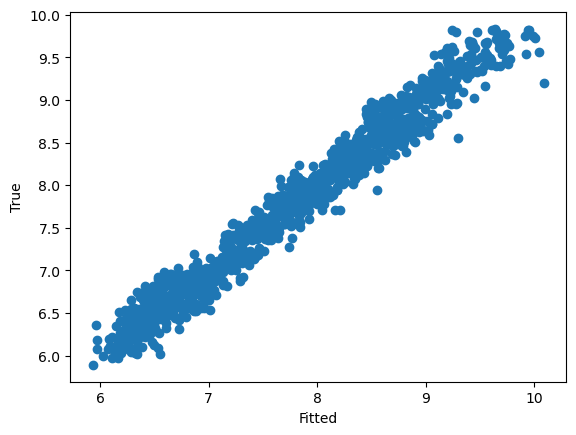

In [255]:
plt.scatter(y_pred,y_test)
plt.xlabel('Fitted')
plt.ylabel('True')

In [257]:
print('Intercept: ', model.intercept_)

intercept =  model.intercept_
Coefficients = model.coef_
Variables = X.loc[:, X.columns].columns.to_numpy()

np.stack((Variables, Coefficients) , axis=1)

Intercept:  4.815026148636344


array([['carat', -4.387837758589638],
       ['depth', 1.066195408993809],
       ['table', 0.1297184162050926],
       ['x', 8.714939247942599],
       ['cut_Good', 0.1321792633069227],
       ['cut_Ideal', 0.2248547865850532],
       ['cut_Premium', 0.1625133881068095],
       ['cut_Very_Good', 0.1843708499239835],
       ['color_Near_Colorless', -0.19454726204421124],
       ['clarity_Medium', 0.28705461587335807],
       ['clarity_Top', 0.5820159364439643]], dtype=object)

The model achive excellent results in predicting the unseen observations. But we can't rely on the values of the coefficients since the normality assumption on the residual are not respected. 

So if Francesco is interested in explaining to his customer why a stone is given a certain value, it could use model_1 (the model without 'carat'), that we have already seen to do well in predicting new observations when we did cross-validation.